In [47]:
!pip install pyspark
!pip install findspark
import findspark
findspark.init()

In [48]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

spark = SparkSession.builder \
    .appName("Online Shoppers Predictions") \
    .getOrCreate()

In [49]:
spark

In [50]:
# load csv
online_shoppers_df = spark.read.format("csv").load("/content/online_shoppers_intention.csv", header=True, inferSchema=True)

In [51]:
# Print of the schema

online_shoppers_df.printSchema()

root
 |-- Administrative: integer (nullable = true)
 |-- Administrative_Duration: double (nullable = true)
 |-- Informational: integer (nullable = true)
 |-- Informational_Duration: double (nullable = true)
 |-- ProductRelated: integer (nullable = true)
 |-- ProductRelated_Duration: double (nullable = true)
 |-- BounceRates: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- SpecialDay: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: integer (nullable = true)
 |-- Browser: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- TrafficType: integer (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: boolean (nullable = true)
 |-- Revenue: boolean (nullable = true)



In [52]:
# print the table
online_shoppers_df.show(5)

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|             0|                    0.0|            0|                   0.0|             1|                    0.0|        0.2|      0.2|       0.0|       0.0|  Feb|               1|      1|     1|          1|Returning_Visitor|  false|  false|
|             0|    

In [53]:
# count the number of rows
online_shoppers_df.count()

12330

In [54]:
# Print unique values
import pandas as pd

operating_systems_unique = online_shoppers_df.select("OperatingSystems").distinct().rdd.flatMap(lambda x: x).collect()

# Unique values of Browser
browser_unique = online_shoppers_df.select("Browser").distinct().rdd.flatMap(lambda x: x).collect()

# Unique values of Region
region_unique = online_shoppers_df.select("Region").distinct().rdd.flatMap(lambda x: x).collect()

# Unique values of TrafficType
traffic_type_unique = online_shoppers_df.select("TrafficType").distinct().rdd.flatMap(lambda x: x).collect()

# Unique values of VisitorType
visitor_type_unique = online_shoppers_df.select("VisitorType").distinct().rdd.flatMap(lambda x: x).collect()

# Unique values of Weekend
weekend_unique = online_shoppers_df.select("Weekend").distinct().rdd.flatMap(lambda x: x).collect()

# Unique values of Revenue
revenue_unique = online_shoppers_df.select("Revenue").distinct().rdd.flatMap(lambda x: x).collect()

# Print the unique values
print("Unique Operating Systems:", operating_systems_unique)
print("Unique Browsers:", browser_unique)
print("Unique Regions:", region_unique)
print("Unique Traffic Types:", traffic_type_unique)
print("Unique Visitor Types:", visitor_type_unique)
print("Unique Weekend Values:", weekend_unique)
print("Unique Revenue Values:", revenue_unique)


Unique Operating Systems: [1, 6, 3, 5, 4, 8, 7, 2]
Unique Browsers: [12, 1, 13, 6, 3, 5, 9, 4, 8, 7, 10, 11, 2]
Unique Regions: [1, 6, 3, 5, 9, 4, 8, 7, 2]
Unique Traffic Types: [12, 1, 13, 6, 16, 3, 20, 5, 19, 15, 9, 17, 4, 8, 7, 10, 11, 14, 2, 18]
Unique Visitor Types: ['New_Visitor', 'Other', 'Returning_Visitor']
Unique Weekend Values: [True, False]
Unique Revenue Values: [True, False]


In [55]:
# statistical measure of Dataframe
online_shoppers_df.describe().show()

+-------+------------------+-----------------------+------------------+----------------------+------------------+-----------------------+--------------------+--------------------+-----------------+-------------------+-----+------------------+------------------+------------------+-----------------+-----------------+
|summary|    Administrative|Administrative_Duration|     Informational|Informational_Duration|    ProductRelated|ProductRelated_Duration|         BounceRates|           ExitRates|       PageValues|         SpecialDay|Month|  OperatingSystems|           Browser|            Region|      TrafficType|      VisitorType|
+-------+------------------+-----------------------+------------------+----------------------+------------------+-----------------------+--------------------+--------------------+-----------------+-------------------+-----+------------------+------------------+------------------+-----------------+-----------------+
|  count|             12330|                  123

In [56]:
# Check and Calculate the count of missing values (nulls) in each column of the DataFrame
from pyspark.sql.functions import isnan, when, count, col

online_shoppers_df.select([count(when(col(c).isNull(), c))
  .alias(c) if online_shoppers_df.schema[c].dataType != 'boolean'
  else count(when(col(c).isNull(), c)).alias(c)
  for c in online_shoppers_df.columns]).show()

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------+-------+-------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|VisitorType|Weekend|Revenue|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------+-------+-------+
|             0|                      0|            0|                     0|             0|                      0|          0|        0|         0|         0|    0|               0|      0|     0|          0|          0|      0|      0|
+--------------+-----------------------+----

In [57]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd


# Convert PySpark DataFrame to Pandas DataFrame
online_shoppers_pandas_df =  online_shoppers_df.toPandas()

# Initialize LabelEncoder
online_shoppers_le = LabelEncoder()

# Apply LabelEncoder to 'Revenue' and 'Weekend' columns
online_shoppers_pandas_df['Revenue'] = online_shoppers_le.fit_transform(online_shoppers_pandas_df['Revenue'])
online_shoppers_pandas_df['Weekend'] = online_shoppers_le.fit_transform(online_shoppers_pandas_df['Weekend'])

# Convert Pandas DataFrame back to PySpark DataFrame
online_shoppers_df_encoded = spark.createDataFrame(online_shoppers_pandas_df)

# Show the resulting DataFrame
online_shoppers_df_encoded.show()


+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|  ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|             0|                    0.0|            0|                   0.0|             1|                    0.0|        0.2|        0.2|       0.0|       0.0|  Feb|               1|      1|     1|          1|Returning_Visitor|      0|      0|
|           

In [58]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Define the categorical columns
online_shoppers_categorical_cols = ['Month', 'VisitorType']

# Initialize StringIndexer for each categorical column
online_shoppers_indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in online_shoppers_categorical_cols]

# Initialize OneHotEncoder for each indexed column
online_shoppers_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=col+"_encoded") for indexer, col in zip(online_shoppers_indexers, online_shoppers_categorical_cols)]

# Define the pipeline
online_shoppers_pipeline = Pipeline(stages=online_shoppers_indexers + online_shoppers_encoders)

# Fit and transform the data using the pipeline
online_shoppers_df_encoded = online_shoppers_pipeline.fit(online_shoppers_df_encoded).transform(online_shoppers_df_encoded)

# Show the resulting DataFrame
online_shoppers_df_encoded.show(100)



+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+-----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+-----------+-----------------+-------------+-------------------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|  ExitRates| PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|Month_index|VisitorType_index|Month_encoded|VisitorType_encoded|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+-----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+-----------+-----------------+-------------+-------------------+
|             0|                    0.0|            0|          

In [59]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col


# Select numeric columns
online_shoppers_numeric_columns = [c for c, dtype in online_shoppers_df_encoded.dtypes if dtype != 'string' and dtype != 'boolean']

# Assemble numeric columns into a single vector
online_shoppers_assembler = VectorAssembler(inputCols=online_shoppers_numeric_columns, outputCol="features")
online_shoppers_df_assembled = online_shoppers_assembler.transform(online_shoppers_df_encoded.select(online_shoppers_numeric_columns))

# Calculate correlation matrix
online_shoppers_correlation_matrix = Correlation.corr(online_shoppers_df_assembled, "features").head()

# Extract the correlation matrix as a numpy array
online_shoppers_correlation_array = online_shoppers_correlation_matrix[0].toArray()

# Print the correlation matrix
print("Correlation Matrix:")
print(online_shoppers_correlation_array)


Correlation Matrix:
[[ 1.00000000e+00  6.01583342e-01  3.76850429e-01  2.55848140e-01
   4.31119340e-01  3.73939013e-01 -2.23562630e-01 -3.16482998e-01
   9.89895854e-02 -9.47775975e-02 -6.34706327e-03 -2.50345723e-02
  -5.48680527e-03 -3.35607126e-02  2.64167503e-02  1.38917094e-01
   3.78794876e-02  1.66801452e-02 -6.45869806e-02  5.15744116e-02
  -5.50356193e-02 -1.44430185e-02  9.12658988e-02  5.96065199e-02
   4.71588774e-02  6.22099758e-03 -1.90238759e-03 -2.28838190e-02
   2.84486753e-02]
 [ 6.01583342e-01  1.00000000e+00  3.02709709e-01  2.38030789e-01
   2.89086621e-01  3.55421954e-01 -1.44170410e-01 -2.05797757e-01
   6.76084809e-02 -7.33037249e-02 -7.34341752e-03 -1.53915267e-02
  -5.56056284e-03 -1.43764306e-02  1.49901419e-02  9.35867191e-02
   1.04703387e-02  1.91201814e-02 -3.93178248e-02  3.24315799e-02
  -2.31981358e-02 -4.99005432e-03  5.51008036e-02  3.13133589e-02
   2.79504935e-02 -2.09577282e-03 -1.89743288e-02 -2.25245274e-02
   2.50433049e-02]
 [ 3.76850429e-01 

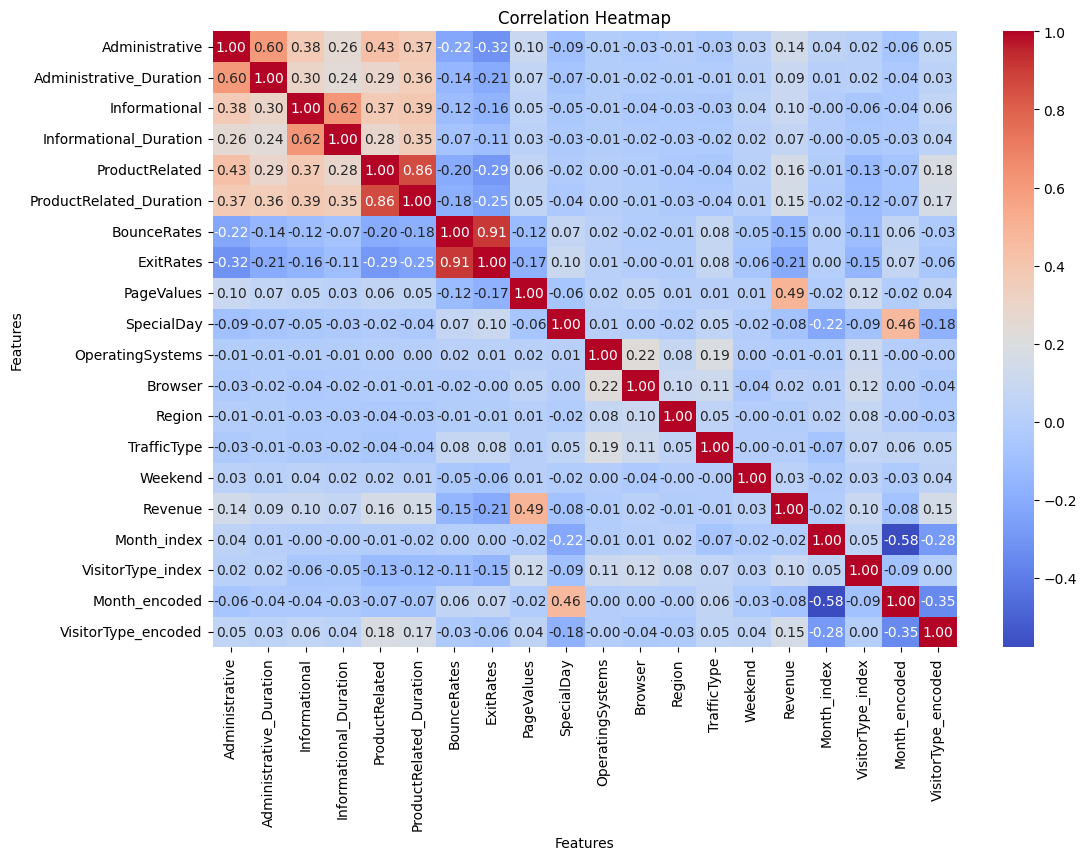

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the correlation matrix array to a Pandas DataFrame
online_shoppers_correlation_df = pd.DataFrame(online_shoppers_correlation_array[:20,:20], columns=online_shoppers_numeric_columns[:20],
                                              index=online_shoppers_numeric_columns[:20])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(online_shoppers_correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()





In [61]:
from google.colab import files
csv_file_path = 'data.csv'  # Specify the file path
online_shoppers_correlation_df.to_csv(csv_file_path, index=False)  # Set index=False to exclude row numbers from the CSV file

# Download CSV file
files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
# Step 1: Split Data into 70% and 30%
train_data, test_data = online_shoppers_df_encoded.randomSplit([0.7, 0.3], seed=42)



In [63]:
# Step 2: Assemble Features
online_shoppers_feature_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                   'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                   'SpecialDay', 'Month_index', 'VisitorType_index', 'Month_encoded', 'VisitorType_encoded']

online_shoppers_assembler = VectorAssembler(inputCols=online_shoppers_feature_columns, outputCol="features")
train_data = online_shoppers_assembler.transform(train_data)
test_data = online_shoppers_assembler.transform(test_data)

In [64]:
# Step 3: Initialize Models
# Initialize Logistic Regression model
online_shoppers_lr = LogisticRegression(labelCol="Revenue", featuresCol="features", maxIter=10)

# Initialize Random Forest model
online_shoppers_rf = RandomForestClassifier(labelCol="Revenue", featuresCol="features", numTrees=10)

# Initialize Gradient-Boosted Tree model
online_shoppers_gbt = GBTClassifier(labelCol="Revenue", featuresCol="features", maxIter=10)

# Initialize Support Vector Machine model
online_shoppers_svm = LinearSVC(labelCol="Revenue", featuresCol="features", maxIter=10)


In [65]:
# Step 4: Train Models
# Train the Logistic Regression model
online_shoppers_lr_model = online_shoppers_lr.fit(train_data)

# Train the Random Forest model
online_shoppers_rf_model = online_shoppers_rf.fit(train_data)

# Train the Gradient-Boosted Tree model
online_shoppers_gbt_model = online_shoppers_gbt.fit(train_data)

# Train the Support Vector Machine model
online_shoppers_svm_model = online_shoppers_svm.fit(train_data)

In [66]:
# Step 5: Make Predictions
# Make predictions using the Logistic Regression model
online_shoppers_lr_predictions = online_shoppers_lr_model.transform(test_data)

# Make predictions using the Random Forest model
online_shoppers_rf_predictions = online_shoppers_rf_model.transform(test_data)

# Make predictions using the Gradient-Boosted Tree model
online_shoppers_gbt_predictions = online_shoppers_gbt_model.transform(test_data)

# Make predictions using the Support Vector Machine model
online_shoppers_svm_predictions = online_shoppers_svm_model.transform(test_data)



In [67]:
# Step 6: Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator
online_shoppers_evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction")

# Evaluate Logistic Regression model
online_shoppers_lr_accuracy = online_shoppers_evaluator.evaluate(online_shoppers_lr_predictions, {online_shoppers_evaluator.metricName: "accuracy"})

# Evaluate Random Forest model
online_shoppers_rf_accuracy = online_shoppers_evaluator.evaluate(online_shoppers_rf_predictions, {online_shoppers_evaluator.metricName: "accuracy"})

# Evaluate Gradient Boosted Tree model
online_shoppers_gbt_accuracy = online_shoppers_evaluator.evaluate(online_shoppers_gbt_predictions, {online_shoppers_evaluator.metricName: "accuracy"})

# Evaluate Support Vector Machine model
online_shoppers_svm_accuracy = online_shoppers_evaluator.evaluate(online_shoppers_svm_predictions, {online_shoppers_evaluator.metricName: "accuracy"})




In [68]:
# Step 7: Report
# Print the accuracies
print("Logistic Regression Accuracy:", online_shoppers_lr_accuracy)
print("Random Forest Accuracy:", online_shoppers_rf_accuracy)
print("Gradient Boosting Accuracy:", online_shoppers_gbt_accuracy)
print("Support Vector Machine Accuracy:", online_shoppers_svm_accuracy)

Logistic Regression Accuracy: 0.8807670928293496
Random Forest Accuracy: 0.8904947192884936
Gradient Boosting Accuracy: 0.906058921623124
Support Vector Machine Accuracy: 0.8827126181211784


In [69]:
from pyspark.ml.evaluation import RegressionEvaluator

# Step 8: Evaluation for Regression Metrics
from pyspark.ml.evaluation import RegressionEvaluator

# Define the evaluators for RMSE, R2, and MAE
online_shoppers_rmse_evaluator = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="rmse")
online_shoppers_r2_evaluator = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="r2")
online_shoppers_mae_evaluator = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="mae")

# Compute RMSE for each model
online_shoppers_lr_rmse = online_shoppers_rmse_evaluator.evaluate(online_shoppers_lr_predictions)
online_shoppers_rf_rmse = online_shoppers_rmse_evaluator.evaluate(online_shoppers_rf_predictions)
online_shoppers_gbt_rmse = online_shoppers_rmse_evaluator.evaluate(online_shoppers_gbt_predictions)
online_shoppers_svm_rmse = online_shoppers_rmse_evaluator.evaluate(online_shoppers_svm_predictions)

# Compute R2 for each model
online_shoppers_lr_r2 = online_shoppers_r2_evaluator.evaluate(online_shoppers_lr_predictions)
online_shoppers_rf_r2 = online_shoppers_r2_evaluator.evaluate(online_shoppers_rf_predictions)
online_shoppers_gbt_r2 = online_shoppers_r2_evaluator.evaluate(online_shoppers_gbt_predictions)
online_shoppers_svm_r2 = online_shoppers_r2_evaluator.evaluate(online_shoppers_svm_predictions)

# Compute MAE for each model
online_shoppers_lr_mae = online_shoppers_mae_evaluator.evaluate(online_shoppers_lr_predictions)
online_shoppers_rf_mae = online_shoppers_mae_evaluator.evaluate(online_shoppers_rf_predictions)
online_shoppers_gbt_mae = online_shoppers_mae_evaluator.evaluate(online_shoppers_gbt_predictions)
online_shoppers_svm_mae = online_shoppers_mae_evaluator.evaluate(online_shoppers_svm_predictions)



In [70]:
# Step 9: Report Regression Metrics
# Print the evaluation results
print("Root Mean Squared Error (RMSE):")
print("Logistic Regression:", online_shoppers_lr_rmse)
print("Random Forest:", online_shoppers_rf_rmse)
print("Gradient Boosting:", online_shoppers_gbt_rmse)
print("Support Vector Machine:", online_shoppers_svm_rmse)

print("\nR-squared (R2):")
print("Logistic Regression:", online_shoppers_lr_r2)
print("Random Forest:", online_shoppers_rf_r2)
print("Gradient Boosting:", online_shoppers_gbt_r2)
print("Support Vector Machine:", online_shoppers_svm_r2)

print("\nMean Absolute Error (MAE):")
print("Logistic Regression:", online_shoppers_lr_mae)
print("Random Forest:", online_shoppers_rf_mae)
print("Gradient Boosting:", online_shoppers_gbt_mae)
print("Support Vector Machine:", online_shoppers_svm_mae)


Root Mean Squared Error (RMSE):
Logistic Regression: 0.345301183274327
Random Forest: 0.3309158211864558
Gradient Boosting: 0.3064980887002006
Support Vector Machine: 0.3424724541898539

R-squared (R2):
Logistic Regression: 0.1169673243894025
Random Forest: 0.189009617271386
Gradient Boosting: 0.30427728588255964
Support Vector Machine: 0.1313757829657991

Mean Absolute Error (MAE):
Logistic Regression: 0.11923290717065037
Random Forest: 0.10950528071150639
Gradient Boosting: 0.09394107837687604
Support Vector Machine: 0.11728738187882157


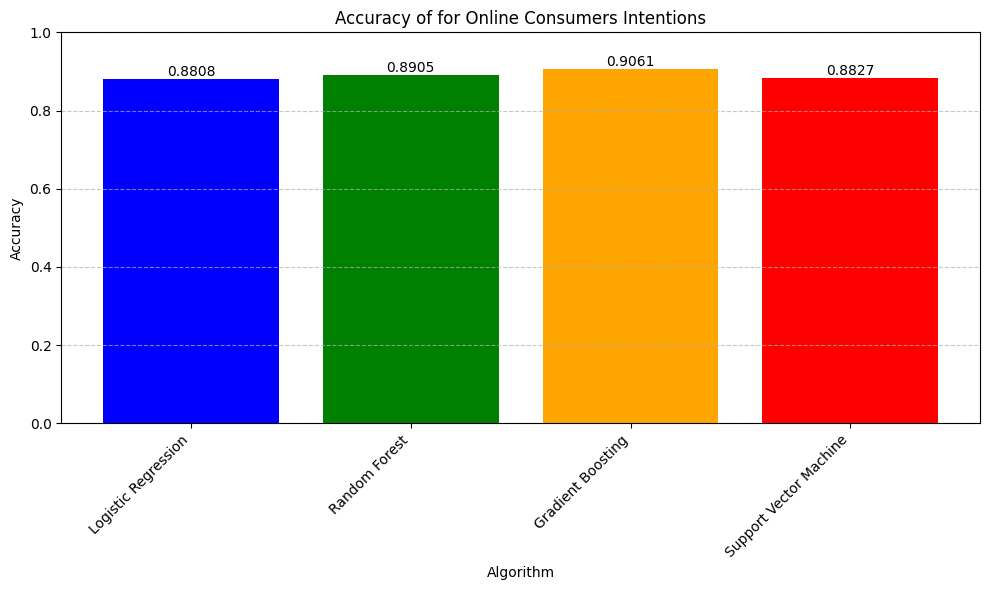

In [71]:
# Plot graph of accuracies

# Define the algorithms and their accuracies
online_shoppers_algorithms = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine']
online_shoppers_accuracies = [online_shoppers_lr_accuracy, online_shoppers_rf_accuracy, online_shoppers_gbt_accuracy, online_shoppers_svm_accuracy]

# Plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(online_shoppers_algorithms, online_shoppers_accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Accuracy of for Online Consumers Intentions')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Add accuracy scores as labels on top of the bars
for bar, accuracy in zip(bars, online_shoppers_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()

# Show the plot
plt.show()



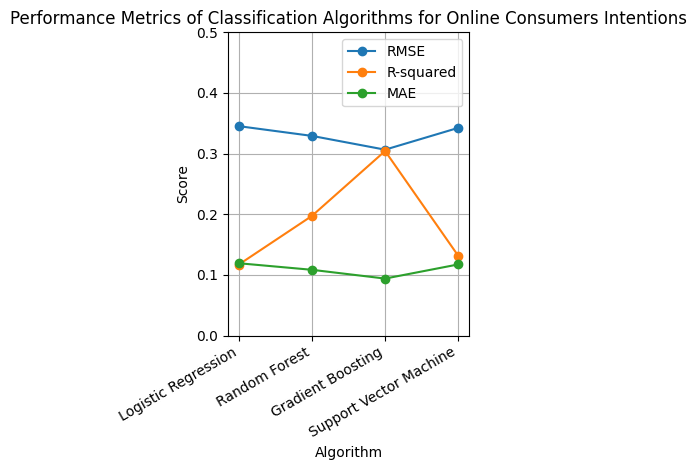

In [72]:
# Plot graph of metrics
# Define the algorithms and their metrics
algorithms = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine']
online_shoppers_rmse_scores = [0.345301183274327, 0.3292317602743066, 0.3064980887002006, 0.3424724541898539]
online_shoppers_r2_scores = [0.1169673243894025, 0.19724302217218426, 0.30427728588255964, 0.1313757829657991]
online_shoppers_mae_scores = [0.11923290717065037, 0.10839355197331851, 0.09394107837687604, 0.11728738187882157]


# Plot metrics
plt.subplot(1, 2, 2)
plt.plot(algorithms, online_shoppers_rmse_scores, marker='o', label='RMSE')
plt.plot(algorithms, online_shoppers_r2_scores, marker='o', label='R-squared')
plt.plot(algorithms, online_shoppers_mae_scores, marker='o', label='MAE')
plt.title('Performance Metrics of Classification Algorithms for Online Consumers Intentions')
plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.ylim(0, 0.5)  # Set y-axis limit
plt.grid(True)
plt.xticks(rotation=30, ha='right')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
